In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
sanjuan_training_dataset = pd.read_csv("drive/My Drive/cdcDengue/dengueData/SanJuan/san_juan_training_data.csv")
print(sanjuan_training_dataset.head())
print("Number of observations: ", len(sanjuan_training_dataset))

      season  season_week week_start_date  denv1_cases  denv2_cases  \
0  1990/1991            1      1990-04-30            0            0   
1  1990/1991            2      1990-05-07            0            0   
2  1990/1991            3      1990-05-14            0            0   
3  1990/1991            4      1990-05-21            0            0   
4  1990/1991            5      1990-05-28            0            0   

   denv3_cases  denv4_cases  other_positive_cases  additional_cases  \
0            0            0                     4                 0   
1            0            0                     5                 0   
2            0            0                     4                 0   
3            0            0                     3                 0   
4            0            0                     6                 0   

   total_cases  
0            4  
1            5  
2            4  
3            3  
4            6  
Number of observations:  988


In [4]:
sanjuan_training_cases = sanjuan_training_dataset["total_cases"].values
print(sanjuan_training_cases.shape)

(988,)


In [5]:
sanjuan_testing_dataset = pd.read_csv("drive/My Drive/cdcDengue/dengueData/SanJuan/san_juan_testing_data.csv")
print(sanjuan_testing_dataset.head())
print("Number of observations: ", len(sanjuan_testing_dataset))

      season  season_week week_start_date  denv1_cases  denv2_cases  \
0  1990/1991            1      1990-04-30            0            0   
1  1990/1991            2      1990-05-07            0            0   
2  1990/1991            3      1990-05-14            0            0   
3  1990/1991            4      1990-05-21            0            0   
4  1990/1991            5      1990-05-28            0            0   

   denv3_cases  denv4_cases  other_positive_cases  additional_cases  \
0            0            0                     4                 0   
1            0            0                     5                 0   
2            0            0                     4                 0   
3            0            0                     3                 0   
4            0            0                     6                 0   

   total_cases  
0            4  
1            5  
2            4  
3            3  
4            6  
Number of observations:  1196


In [6]:
sanjuan_testing_cases = sanjuan_testing_dataset["total_cases"].values
print(sanjuan_testing_cases.shape)

(1196,)


In [0]:
def series_to_timeseries_window(data, windowSize, future_steps):
    x = []
    y = []
    for i in range(len(data)-windowSize-future_steps):
        x_observation = []
        y_observation = [data[i+windowSize+future_steps]]
        for j in range(windowSize):
            x_observation.append(data[i+j])
        x.append(x_observation)
        y.append(y_observation)
    return np.array(x), np.array(y)

In [8]:
#Test that the method works
test_data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

tX, ty = series_to_timeseries_window(test_data, 4, 3)

print(tX)
print(ty)

print(len(tX))

[[ 1  2  3  4]
 [ 2  3  4  5]
 [ 3  4  5  6]
 [ 4  5  6  7]
 [ 5  6  7  8]
 [ 6  7  8  9]
 [ 7  8  9 10]
 [ 8  9 10 11]]
[[ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]]
8


In [9]:
window_size = 4
steps = 4
split_index = len(sanjuan_training_cases)
reframed_X, reframed_y = series_to_timeseries_window(sanjuan_testing_cases, window_size, steps-1)

print("reframed_X: ", reframed_X.shape)
print("reframed_y: ", reframed_y.shape)
# shape = size - window_size

train_X = reframed_X[:split_index-window_size-(steps-1)]
train_y = reframed_y[:split_index-window_size-(steps-1)]

test_X = reframed_X[split_index-window_size-(steps-1):]
test_y = reframed_y[split_index-window_size-(steps-1):]

train_X = train_X.reshape(train_X.shape[0], 1, train_X.shape[1])

test_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])

print(train_X.shape)
print(train_y.shape)

print(test_X.shape)
print(test_y.shape)

reframed_X:  (1189, 4)
reframed_y:  (1189, 1)
(981, 1, 4)
(981, 1)
(208, 1, 4)
(208, 1)


## Train model

In [10]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Flatten
from keras.layers.merge import concatenate
from keras.constraints import non_neg
from keras.models import Model
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam
input_layer = Input(shape=(1,4))
b1_out = LSTM(64, return_sequences=False)(input_layer)

b2_out = Dense(32, activation="relu", kernel_regularizer="l2")(input_layer)
b2_out = Flatten()(b2_out)

concatenated = concatenate([b1_out, b2_out])
out = Dense(4, activation="relu", kernel_regularizer="l2")(concatenated)
out = Dense(4, activation="relu", kernel_regularizer="l2")(out)
out = Dense(1, activation="linear", kernel_constraint=non_neg(), name='output_layer')(out)

model = Model([input_layer], out)
model.compile(loss=["mse"], optimizer=Adam(0.0001), metrics=["mae", "mse"])

history = model.fit(train_X, train_y, epochs=200, batch_size=32, verbose=0, shuffle=False)


Using TensorFlow backend.


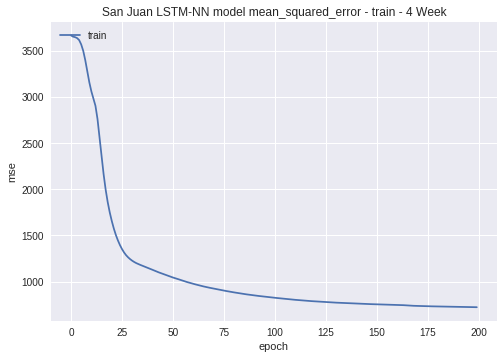

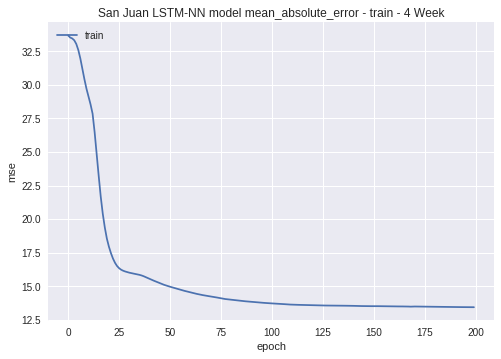

In [11]:
plt.plot(history.history['mean_squared_error'])
plt.title('San Juan LSTM-NN model mean_squared_error - train - 4 Week')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['mean_absolute_error'])
plt.title('San Juan LSTM-NN model mean_absolute_error - train - 4 Week')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
## Time series cross validation
history_X = [x for x in train_X]
history_y = [y for y in train_y]

predicted_y_history = []
for i in range(len(test_X)):
  expected_y = test_y[i]
  predicted_y = model.predict(test_X[i].reshape(1,1,4))[0]
#   print("Expected {}, got {}.".format(expected_y, predicted_y))
  predicted_y_history.append(predicted_y[0])
  
  history_X.append(test_X[i])
  history_y.append(expected_y)

  model.fit(np.array(history_X), np.array(history_y), epochs=1, batch_size=32, verbose=0, shuffle=False)
# Save model
model.save("drive/My Drive/cdcDengue/SanJuanModels/4Weeks/4Week.h5")

In [13]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test_y, predicted_y_history)

print("MSE: ", error)

MSE:  823.815800530694


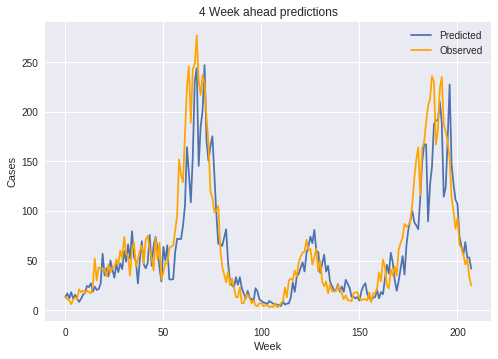

In [14]:
plt.title("4 Week ahead predictions")
plt.xlabel("Week")
plt.ylabel("Cases")
plt.plot(predicted_y_history, label="Predicted")
plt.plot(test_y, label = "Observed", color="orange")
plt.legend()
plt.show()

In [0]:
df = pd.DataFrame(predicted_y_history)
df.to_csv("drive/My Drive/cdcDengue/SanJuanModels/4Weeks/4Week.csv")